In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting

import sys
sys.path.append("../../wuchengzhou")
import sagan

import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

ls_km = 2.99792e5 # km/s

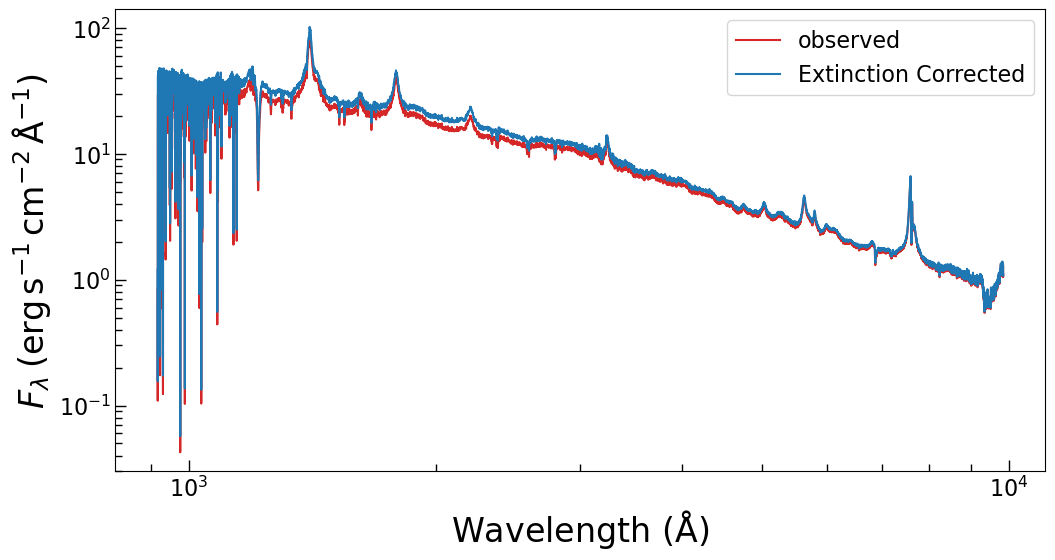

In [2]:
# load & draw the spectrum, correct the mlk way extinction
data_path = '../data/spectra/3c273sed.fit'
hdul = fits.open(data_path)
header = hdul[0].header
flux = hdul[0].data * 1e14

# for key, value in header.items():
#     print(f"{key}: {value}")

w0 = header['CRVAL1']
dw = header['CD1_1']
wave = w0 + dw * np.arange(flux.size)

from extinction import ccm89, remove

# Find the V band attenuation from https://ned.ipac.caltech.edu/ -- FOREGROUND GALACTIC EXTINCTION

A_V = 0.057
flux_dred = remove(ccm89(wave, A_V, r_v=3.1, unit='aa'), flux)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(wave, flux, label='observed', color='C3')
ax.step(wave, flux_dred, label='Extinction Corrected', color='C0')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\AA^{-1}})$', fontsize=24)
ax.legend(fontsize=16)
ax.set_ylim(0.03, 140)
ax.minorticks_on()
plt.show()

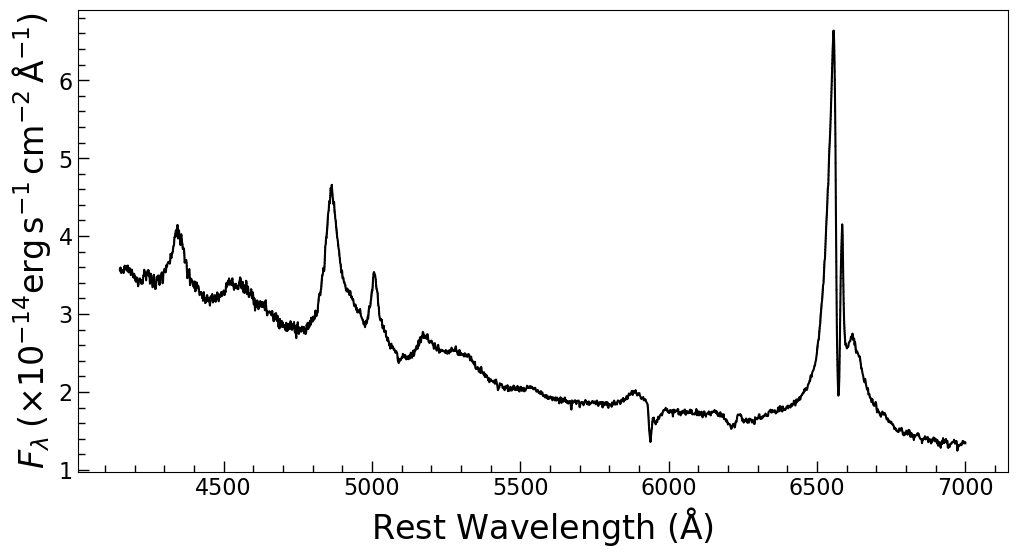

In [3]:
# cut the useful data and move to the rest frame
zred = 0.1576

fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 4150, 7000
wave_rst = wave / (1 + zred)
fltr = (wave_rst > wmin) & (wave_rst < wmax)
wave_use = wave_rst[fltr]
flux_use = flux_dred[fltr]


ax.step(wave_use, flux_use, color='k')
ax.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\times 10^{-14} \mathrm{erg\,s^{-1}\,cm^{-2}\,\AA^{-1}})$', fontsize=24)
ax.minorticks_on()
plt.show()

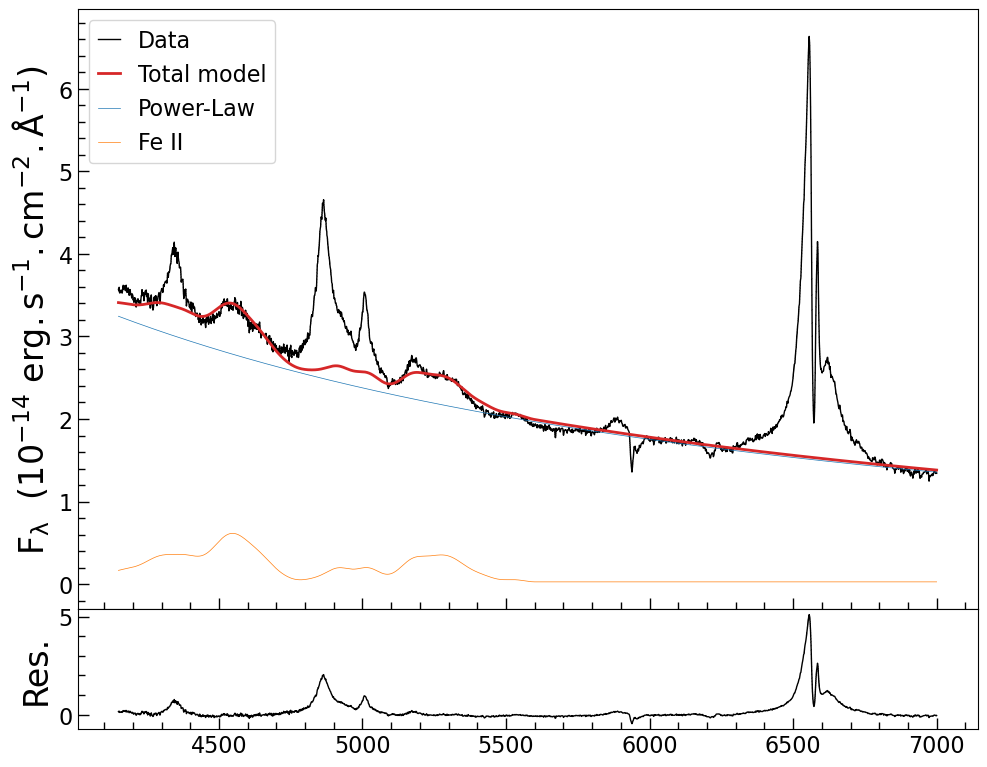

<PowerLaw1D(amplitude=2.02722347, x_0=5500., alpha=1.67044874, name='Power-Law')>
<IronTemplate(amplitude=0.9359741, stddev=2938.89416904, z=0., name='Fe II')>


In [6]:
# fit the continuum
from mask import mask

mask = mask(np.vstack((wave_use, flux_use)), window_size=int(0.01*len(wave_use)), threshold=(0.3, 0.1))

pl = models.PowerLaw1D(amplitude=1, x_0=5500, alpha=0.5, fixed={'x_0': True}, name='Power-Law', bounds={'alpha':(-5, 5)})

iron = sagan.IronTemplate(amplitude=1, stddev=400, z=0, name='Fe II')
iron.z.fixed = True

cont_init = pl + iron

fitter = fitting.LevMarLSQFitter()

m_fit_cont = fitter(cont_init, wave_use, flux_use, maxiter=10000, weights=mask)

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit_cont)
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-14} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)

plt.show()

for m in m_fit_cont:
    print(m.__repr__())

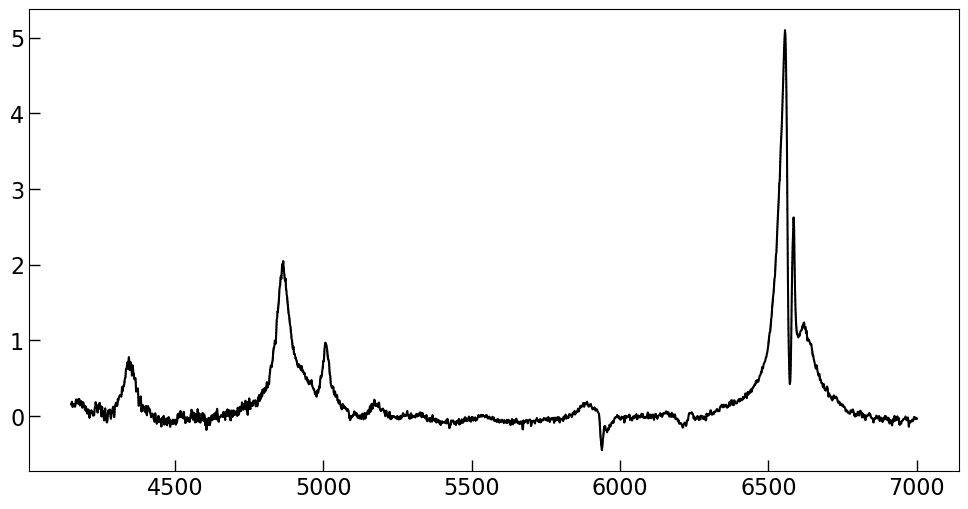

In [7]:
flux_res = flux_use - m_fit_cont(wave_use)
fig, ax = plt.subplots(figsize=(12, 6))
ax.step(wave_use, flux_res, color='k')

In [ ]:
wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict

b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=2.0, sigma_c=1400, wavec=wave_dict['Halpha'], name=label_dict['Halpha'], amp_w0=0.3, sigma_w0=6000)
b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=1.3, sigma_c=1100, wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'], amp_w0=0.5, sigma_w0=4000)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.6, sigma_c=1400, wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])

b_HeI = sagan.Line_MultiGauss(n_components=1, amp_c=0.2, sigma_c=1600, wavec=5875.624, name=f'He I 5876')
b_FeII = sagan.Line_MultiGauss(n_components=1, amp_c=0.12, sigma_c=5744, wavec=5169.033, name=f'Fe II 5169')

n_ha = sagan.Line_MultiGauss(n_components=2, amp_c=2.3, wavec=wave_dict['Halpha'], name=f'narrow {label_dict["Halpha"]}')
n_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.01, wavec=wave_dict['Hbeta'], name=f'narrow {label_dict["Hbeta"]}')
n_hg = sagan.Line_MultiGauss(n_components=2, amp_c=0.12, wavec=wave_dict['Hgamma'], name=f'narrow {label_dict["Hgamma"]}')

line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=0.6, amp_c1=0.2, dv_c=0, sigma_c=700, wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]', amp_w0=0.3, dv_w0=-400, sigma_w0=1200)

line_ha = b_ha + n_ha
line_hb = b_hb + n_hb
line_hg = b_hg + n_hg

# def model
m_init = (line_ha + line_hb + line_hg + line_o3 + b_FeII + b_HeI)

# tie args
def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

def tie_narrow_sigma_c(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv_c(model):
    return model['[O III]'].dv_c

def tie_narrow_amp_w0(model):
    return model['[O III]'].amp_w0

def tie_narrow_sigma_w0(model):
    return model['[O III]'].sigma_w0

def tie_narrow_dv_w0(model):
    return model['[O III]'].dv_w0


for line in [n_ha, n_hb, n_hg]:
    line.sigma_c.tied = tie_narrow_sigma_c
    line.dv_c.tied = tie_narrow_dv_c
    line.amp_w0.tied = tie_narrow_amp_w0
    line.sigma_w0.tied = tie_narrow_sigma_w0
    line.dv_w0.tied = tie_narrow_dv_w0

# fitting
fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
fltr1 = (wave_use > 5910) & (wave_use < 6000)
fltr2 = (wave_use > 6559) & (wave_use < 6630)
fltr = fltr1 | fltr2
weights[fltr] = 0.
m_fit = fitter(m_init, wave_use, flux_res, weights=weights, maxiter=50000)

ax, axr = sagan.plot.plot_fit(wave_use, flux_res, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\times 10^{-14}\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.axvspan(5910, 6000, color='gray', alpha=0.5)
ax.axvspan(6559, 6630, color='gray', alpha=0.5)
axr.axvspan(5910, 6000, color='gray', alpha=0.5)
axr.axvspan(6559, 6630, color='gray', alpha=0.5)
axr.set_ylim(-0.25, 0.25)  # 限制axr的y轴范围
plt.show()


for m in m_fit:
    print(m.__repr__())